### TYK2 Full-Length FlowDMS Variant Interpretation

1. [Allele Frequencies](#part1)
2. [ClinVar](#part2)
3. [EVE and ESM1b](#part3)
4. [SIFT and Polyphen2](#part4)
5. [AlphaMissense](#part5)

In [149]:
library(ggpubr)
library(ggsci)
library(patchwork)
library(ggbeeswarm)
library(tidyverse)

In [69]:
aalet <- read_tsv("../data/annotations/aa-letters.tsv", col_names = c("full", "thr", "aa")) %>%
    select(-full)
wtseq <- read_tsv("../data/annotations/TYK2-sequence.tsv", col_names = c("pos", "thr"), skip = 1) %>%
    left_join(aalet, by = "thr") %>%
    rename("wt_aa" = "aa",
           "wt_thr" = "thr")

Rows: 22 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): full, thr, aa

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1187 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): thr
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [73]:
sumstats <- read_tsv("../sumstats/TYK2-VAMP/run2/OCNT-VAMPLIB-1-assay-run2-vampseq-midpoints.sumstats.tsv") %>%
    left_join(wtseq, by = "pos") %>%
    left_join(aalet %>% rename("mut_thr" = "thr"), by = c("mut_aa" = "aa")) %>%
    mutate(mut = paste0(wt_thr, pos, mut_thr))

Rows: 23567 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chunk, mut_aa
dbl (10): score_mean, score_se, pos, WT score, WT score standard error, esti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Allele Frequencies <a name="part1"></a>

Each variant has a population-level allele frequency, which we can plot for each global population for which we have data from Gnomad. In the plots below, red points are significant in the DMS data at an adjusted p-value < 0.01:

In [75]:
varinfo <- read_tsv("../data/annotations/TYK2-vep.tsv.gz", comment = "##") %>%
    filter(Feature == "ENST00000525621", grepl("missense", Consequence)) %>%
    select(Protein_position, Amino_acids, matches("gnomAD")) %>%
    pivot_longer(names_to = "group", values_to = "allele_frequency", matches("gnomAD")) %>%
    filter(allele_frequency != "-") %>%
    mutate(allele_frequency = as.numeric(allele_frequency)) %>%
    group_by(Protein_position, Amino_acids, group) %>%
    summarize(allele_frequency = sum(allele_frequency)) %>%
    separate(Amino_acids, c("wt_aa", "mut_aa"), "/") %>%
    rename("pos" = "Protein_position") %>%
    mutate(pos = as.numeric(pos))

sumstats_vep <- sumstats %>%
    inner_join(varinfo, by = c("pos" = "pos",
                               "mut_aa" = "mut_aa"))

Rows: 24326 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (28): #Uploaded_variation, Location, Allele, Gene, Feature, Feature_type...
dbl  (1): STRAND

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Protein_position', 'Amino_acids'. You can
override using the `.groups` argument.


In [146]:
gnomad_scatter <- sumstats_vep %>%
    ggplot() +
        geom_point(aes(x = statistic,
                       y = log10(allele_frequency),
                       color = if_else(p.adj < 0.01, "red", "black")),
                   alpha = 0.5) +
        theme_pubr(base_size = 16) +
        facet_wrap(~group, nrow = 2) +
        xlab("FlowDMS Mutant minus WT Z-Statistic") + ylab("log10(allele frequency)") +
        scale_color_identity() +
        ggtitle("FlowDMS in Gnomad")

gnomad_scatter_global <- sumstats_vep %>%
    filter(group == "gnomADe_AF") %>%
    ggplot() +
        geom_point(aes(x = statistic,
                       y = log10(allele_frequency),
                       color = if_else(p.adj < 0.01, "red", "black")),
                   alpha = 0.5) +
        theme_pubr(base_size = 16) +
        xlab("FlowDMS Mutant minus WT Z-Statistic") + ylab("log10(allele frequency)") +
        scale_color_identity() +
        ggtitle("FlowDMS in Gnomad")

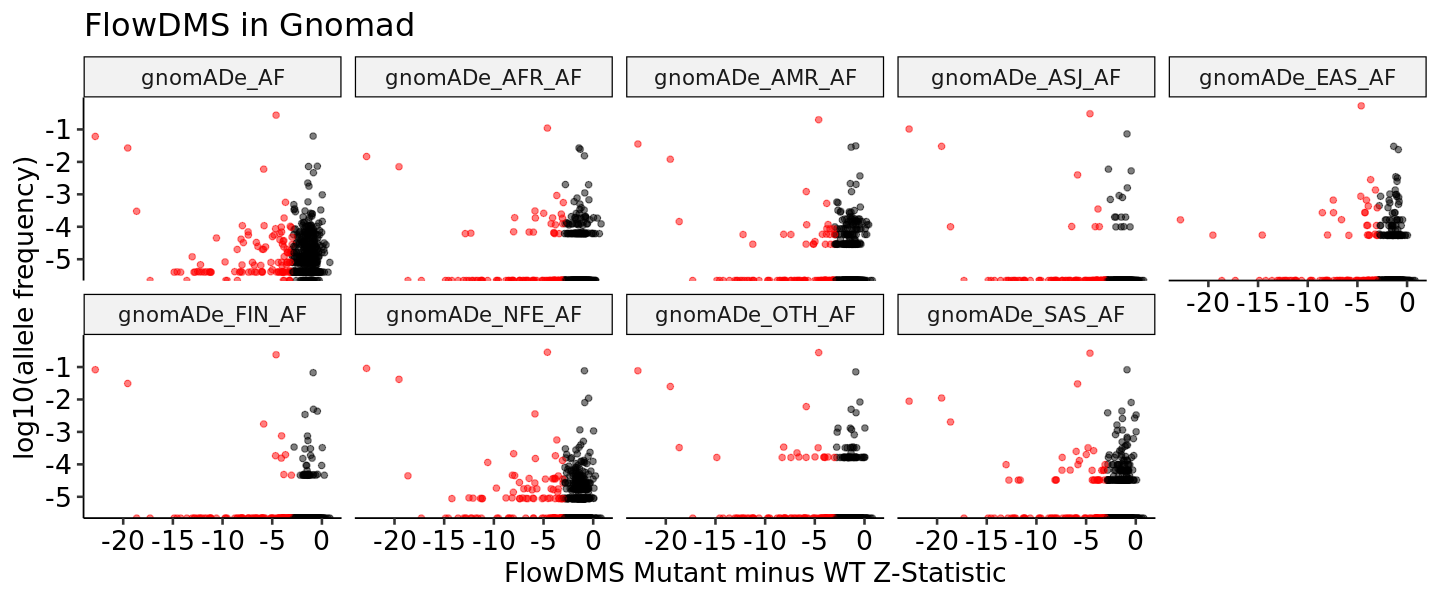

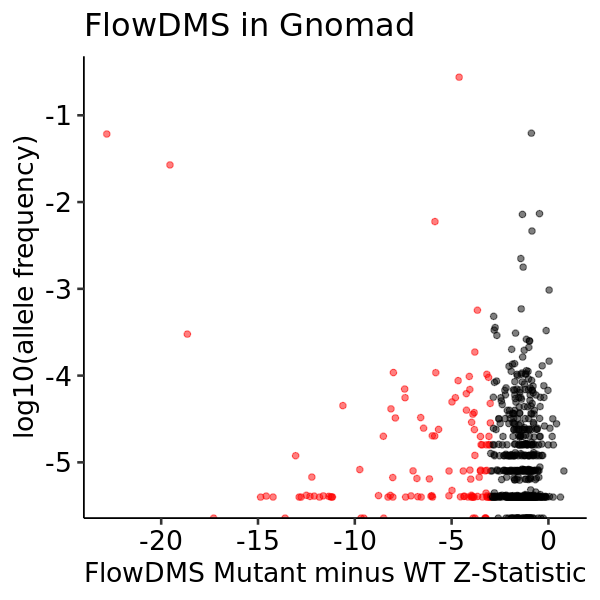

In [148]:
options(repr.plot.width = 12, repr.plot.height = 5)
gnomad_scatter
options(repr.plot.width = 5, repr.plot.height = 5)
gnomad_scatter_global

In [45]:
ggsave("../dataviz/TYK2/vampseq/TYK2-VAMP-Gnomad.pdf",
       gnomad_scatter,
       height = 5, width = 12)x 

ggsave("../dataviz/TYK2/vampseq/TYK2-VAMP-Gnomad-GlobalOnly.pdf",
       gnomad_scatter_global,
       height = 5, width = 5)

#### ClinVar <a name="part2"></a>

There are 316 missense variants in TYK2 noted in ClinVar, which we can compare to our data stratified by ClinVar classification from Benign to Pathogenic. Notably, P1104A is classified as Benign/Likely Benign, so there is not necessairly a strong expectation that our functional effects should associate strongly with a ClinVar class:

In [79]:
tyk2_clinvar <- read_tsv("../data/annotations/TYK2-clinvar-missense.tsv.gz") %>%
    select(Name, `Clinical significance (Last reviewed)`) %>%
    rename("class" = "Clinical significance (Last reviewed)") %>%
    separate(Name, c("id", "mut"), sep = " ") %>%
    mutate(mut = gsub("\\(|\\)|p.","",mut),
           class = gsub("\\(.*","",class)) %>%
    select(-id) %>%
    distinct()

New names:
• `` -> `...16`
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 316 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Name, Gene(s), Protein change, Condition(s), Clinical significance ...
dbl (6): GRCh37Chromosome, GRCh37Location, GRCh38Chromosome, GRCh38Location,...
lgl (1): ...16

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


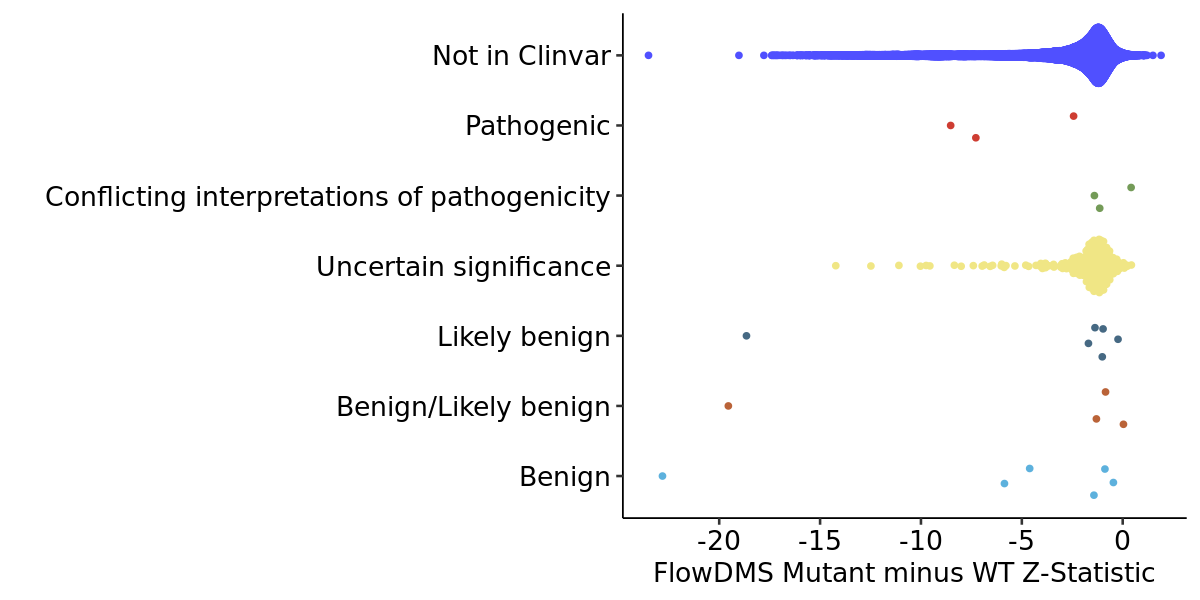

In [83]:
options(repr.plot.width = 10, repr.plot.height = 5)
sumstats %>%
    left_join(tyk2_clinvar, by = "mut") %>%
    mutate(class = if_else(is.na(class), "Not in Clinvar", class),
           class = factor(class, levels = c("Not in Clinvar",
                                            "Pathogenic",
                                            "Conflicting interpretations of pathogenicity",
                                            "Uncertain significance",
                                            "Likely benign",
                                            "Benign/Likely benign",
                                            "Benign"))) %>%
    ggplot(aes(y = statistic, x = fct_rev(class), color = class)) +
        geom_quasirandom() +
        theme_pubr(base_size = 16) +
        ylab("FlowDMS Mutant minus WT Z-Statistic") + xlab("") +
        coord_flip() +
        theme(legend.pos = "none") +
        scale_color_igv()

The vast majority of variants are either not in ClinVar, or are of uncertain significance. So, if we extract all variants NOT in either of those two categories, we can show them together in a table with the DMS adjusted p-value:

In [109]:
sumstats %>%
    left_join(tyk2_clinvar, by = "mut") %>%
    mutate(class = if_else(is.na(class), "Not in Clinvar", class),
           class = factor(class, levels = c("Not in Clinvar",
                                            "Pathogenic",
                                            "Conflicting interpretations of pathogenicity",
                                            "Uncertain significance",
                                            "Likely benign",
                                            "Benign/Likely benign",
                                            "Benign"))) %>%
    filter(!class %in% c("Not in Clinvar", "Uncertain significance")) %>%
    select(mut, class, estimate, p.adj) %>%
    arrange(class) %>%
    rename("midpoint shift" = "estimate",
           "mutation" = "mut",
           "ClinVar category" = "class",
           "DMS adjusted p-value" = "p.adj")

mutation,ClinVar category,midpoint shift,DMS adjusted p-value
<chr>,<fct>,<dbl>,<dbl>
Leu1014Pro,Pathogenic,-0.398049762,3.056952e-12
Leu757Val,Pathogenic,-0.308629769,4.486910e-02
Gly799Arg,Pathogenic,-0.421945818,1.730525e-16
Arg701Thr,Conflicting interpretations of pathogenicity,-0.126109050,3.507835e-01
Gly512Arg,Conflicting interpretations of pathogenicity,-0.192161858,2.693573e-01
Arg118Gln,Conflicting interpretations of pathogenicity,0.042268295,7.059977e-01
Pro871Ser,Likely benign,-0.193946073,1.832957e-01
Gly39Ser,Likely benign,-0.034260258,8.342422e-01
His993Tyr,Likely benign,-0.110472522,3.953974e-01


#### EVE and ESM1b <a name="part3"></a>

EVE (both scores from the Marks lab) and ESB1b have extremely similar patterns:

In [86]:
eve_scores_b05 <- read_csv("../data/annotations/TYK2_HUMAN_b05_20000_samples.csv") %>%
    mutate(mutations = gsub("^.","",mutations)) %>%
    select(-protein_name) %>%
    filter(mutations != "t") %>%
    separate(mutations, c("pos", "aa"), sep = -1) %>%
    rename("EVE Score 1" = "evol_indices") %>%
    mutate(pos = as.numeric(pos))

eve_scores_b03 <- read_csv("../data/annotations/TYK2_HUMAN_b03_20000_samples.csv") %>%
    mutate(mutations = gsub("^.","",mutations)) %>%
    select(-protein_name) %>%
    filter(mutations != "t") %>%
    separate(mutations, c("pos", "aa"), sep = -1) %>%
    rename("EVE Score 2" = "evol_indices") %>%
    mutate(pos = as.numeric(pos))

eve_scores <- inner_join(eve_scores_b05, eve_scores_b03, by = c("pos", "aa"))

Rows: 19153 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): protein_name, mutations
dbl (1): evol_indices

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 19913 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): protein_name, mutations
dbl (1): evol_indices

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


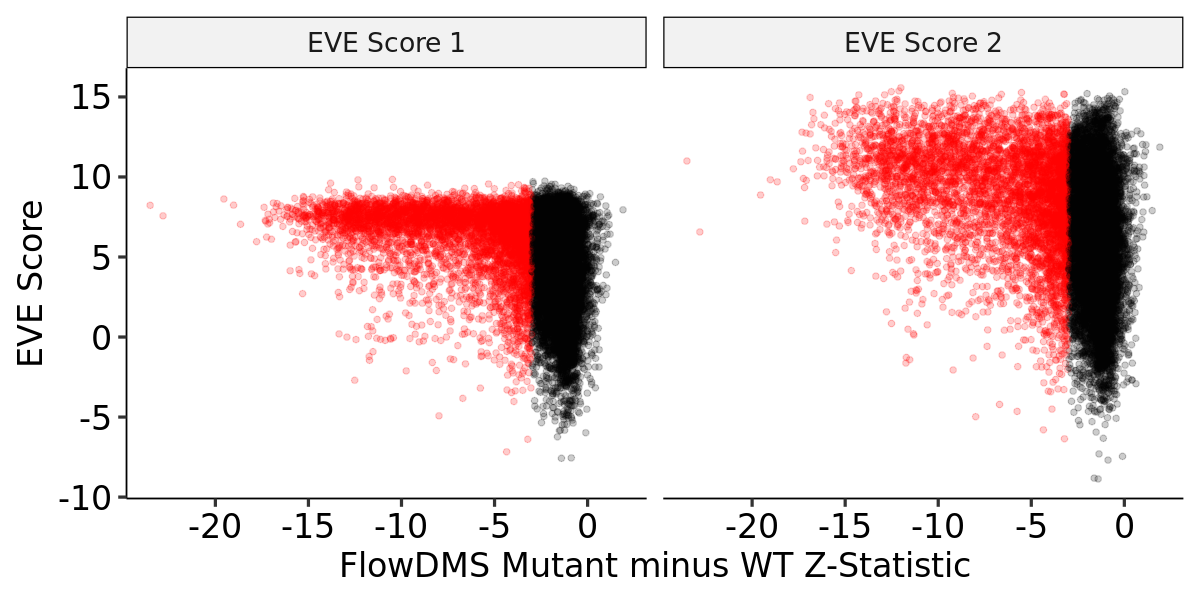

In [112]:
options(repr.plot.witdh = 10, repr.plot.height = 5)
sumstats %>%
    inner_join(eve_scores, by = c("pos", "mut_aa" = "aa")) %>%
    pivot_longer(names_to = "stat", values_to = "eve_score", `EVE Score 1`:`EVE Score 2`) %>%
    ggplot() +
        geom_point(aes(x = statistic, y = eve_score,
                       color = case_when(p.adj < 0.01 ~ "red",
                                         TRUE ~ "black")), alpha = 0.2) +
        theme_pubr(base_size = 20) +
        facet_wrap(~stat, nrow = 1) +
        xlab("FlowDMS Mutant minus WT Z-Statistic") + ylab("EVE Score") +
        scale_color_identity()

In [128]:
esm1b <- read_csv("../data/annotations/TYK2-ESM1b.csv") %>%
    mutate(wt_aa = str_sub(variant, 1, 1),
           mut_aa = str_sub(variant, -1))

Rows: 23740 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): variant
dbl (2): score, pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


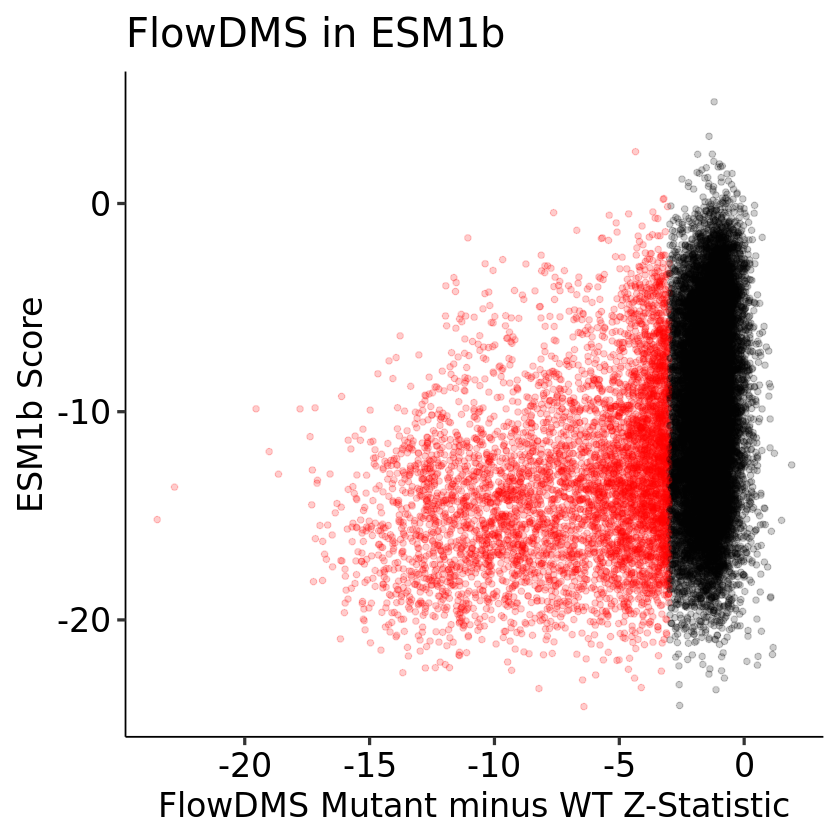

In [134]:
options(repr.plot.width = 7, repr.plot.height = 7)
sumstats %>%
    inner_join(esm1b, by = c("pos", "mut_aa")) %>%
    ggplot() +
        geom_point(aes(x = statistic, y = score,
                   color = case_when(p.adj < 0.01 ~ "red",
                                         TRUE ~ "black")), alpha = 0.2)  +
        theme_pubr(base_size = 20) +
        xlab("FlowDMS Mutant minus WT Z-Statistic") + ylab("ESM1b Score") +
        ggtitle("FlowDMS in ESM1b") +
        scale_color_identity()

#### SIFT and PolyPhen2 <a name="part4"></a>

The older predictors also have L-shaped patterns, though with visibly lower resolution to distinguish between similar variants:

In [115]:
tyk2_sift <- read_delim("../data/annotations/TYK2-sift.tsv.gz", delim = " ") %>%
    pivot_longer(names_to = "aa", values_to = "sift", A:Y) %>%
    mutate(mut = paste0(wt, aa)) %>%
    select(mut, sift)

tyk2_polyp <- read_tsv("../data/annotations/TYK2-polyphen2.tsv.gz") %>%
    select(o_pos, o_aa2, pph2_prob) %>%
    rename("PolyPhen2" = "pph2_prob")

sumstats_siftphen <- sumstats %>%
    mutate(mut = paste0(pos, wt_aa, mut_aa)) %>%
    left_join(tyk2_sift, by = "mut") %>%
    left_join(tyk2_polyp, by = c("pos" = "o_pos",
                                 "mut_aa" = "o_aa2"))

Rows: 1187 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr  (1): wt
dbl (21): cons, A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 22558 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): #o_acc, o_aa1, o_aa2, rsid, acc, aa1, aa2, prediction
dbl (5): o_pos, pos, pph2_prob, pph2_FPR, pph2_TPR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


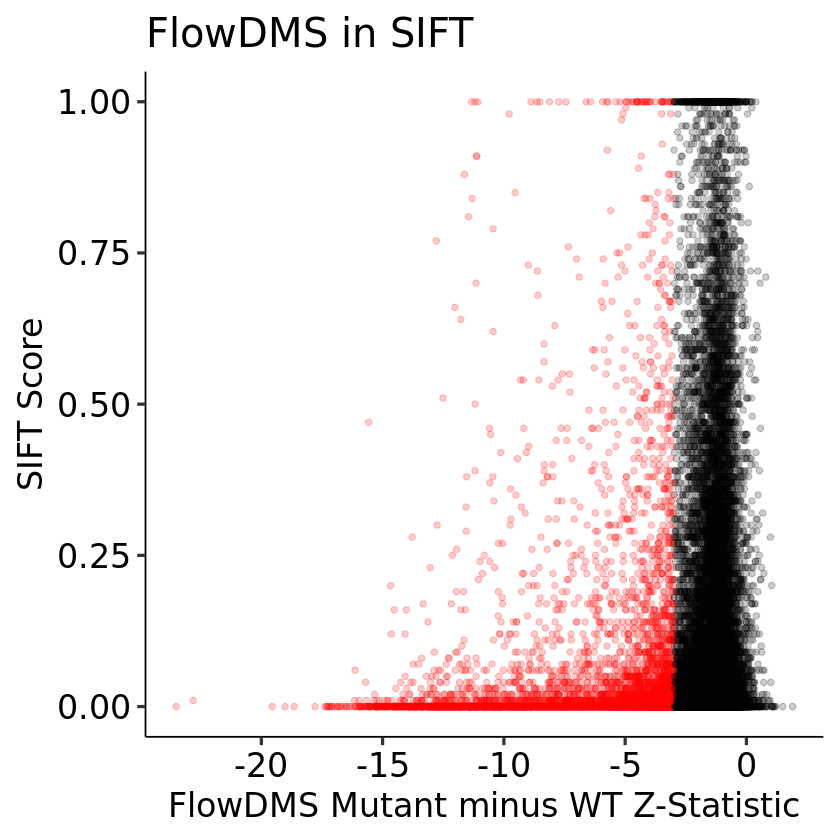

In [145]:
options(repr.plot.width = 7, repr.plot.height = 7, warn = -1)
sumstats_siftphen %>%
    ggplot() +
        geom_point(aes(x = statistic, y = sift,
                   color = case_when(p.adj < 0.01 ~ "red",
                                         TRUE ~ "black")), alpha = 0.2)  +
        theme_pubr(base_size = 20) +
        xlab("FlowDMS Mutant minus WT Z-Statistic") + ylab("SIFT Score") +
        ggtitle("FlowDMS in SIFT") +
        scale_color_identity()

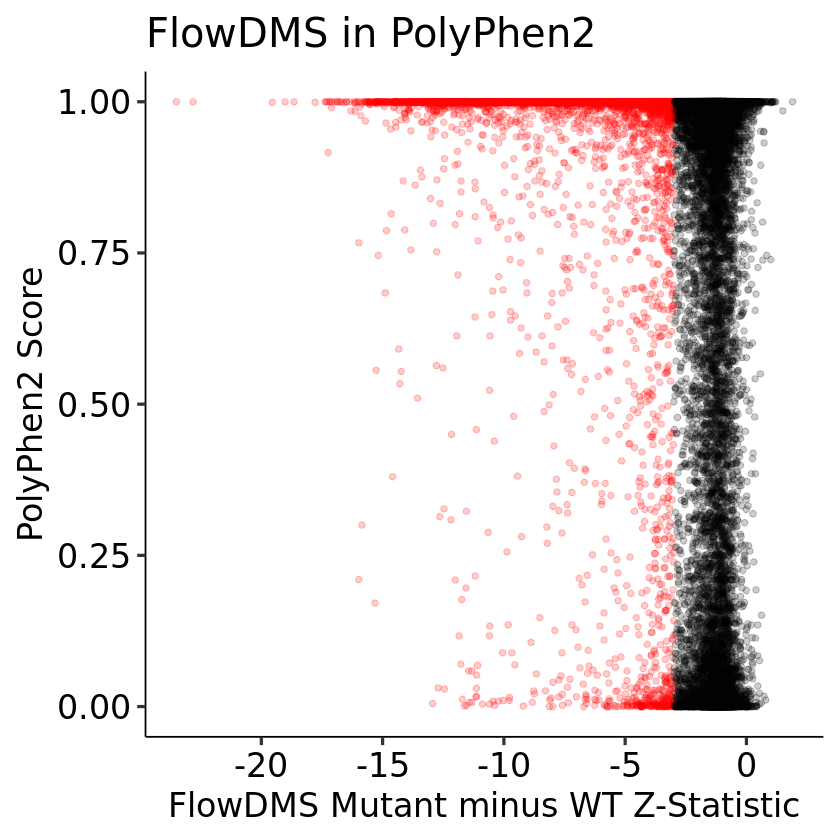

In [144]:
options(repr.plot.width = 7, repr.plot.height = 7, warn = -1)
sumstats_siftphen %>%
    ggplot() +
        geom_point(aes(x = statistic, y = PolyPhen2,
                   color = case_when(p.adj < 0.01 ~ "red",
                                         TRUE ~ "black")), alpha = 0.2)  +
        theme_pubr(base_size = 20) +
        xlab("FlowDMS Mutant minus WT Z-Statistic") + ylab("PolyPhen2 Score") +
        ggtitle("FlowDMS in PolyPhen2") +
        scale_color_identity()

#### AlphaMissense <a name="part5"></a>

Comparing AlphaMissense variant effect predictions with TYK2 VAMP-seq for chunk 10.

In [137]:
alphamissense <- read_tsv("../data/annotations/tyk2-alphamissense.tsv",
                          col_names = c("uniprot_id" ,"mut_id", "score", "AlphaMissense Class"))

Rows: 22553 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): uniprot_id, mut_id, AlphaMissense Class
dbl (1): score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [138]:
p1 <- sumstats %>%
    mutate(mut_id = str_c(wt_aa, pos, mut_aa)) %>%
    left_join(alphamissense) %>%
    ggplot() +
        geom_point(aes(y = estimate, x = score, color = `AlphaMissense Class`)) +
        theme_pubr() +
        ylab("FlowDMS Estimated Midpoint Shift, Chunk 10") +
        xlab("Alpha-Missense Score") +
        scale_color_manual(values = c("pathogenic" = "blue", "ambiguous" = "red", "benign" = "darkgreen"))

p2 <- sumstats %>%
    mutate(mut_id = str_c(wt_aa, pos, mut_aa)) %>%
    left_join(alphamissense) %>% 
    mutate(`AlphaMissense Class` = factor(`AlphaMissense Class`, levels = c("benign", "ambiguous", "pathogenic"))) %>%
    filter(!is.na(`AlphaMissense Class`)) %>%
    ggplot() +
        geom_quasirandom(aes(y = estimate, x = `AlphaMissense Class`, color = `AlphaMissense Class`)) +
        geom_boxplot(aes(y = estimate, x = `AlphaMissense Class`, color = `AlphaMissense Class`), width = 0.2) +
        theme_pubr() +
        ylab("FlowDMS Estimated Midpoint Shift, Chunk 10") +
        xlab("Alpha-Missense Predicted Class") +
        scale_color_manual(values = c("pathogenic" = "blue", "ambiguous" = "red", "benign" = "darkgreen"))

Joining with `by = join_by(mut_id)`
Joining with `by = join_by(mut_id)`


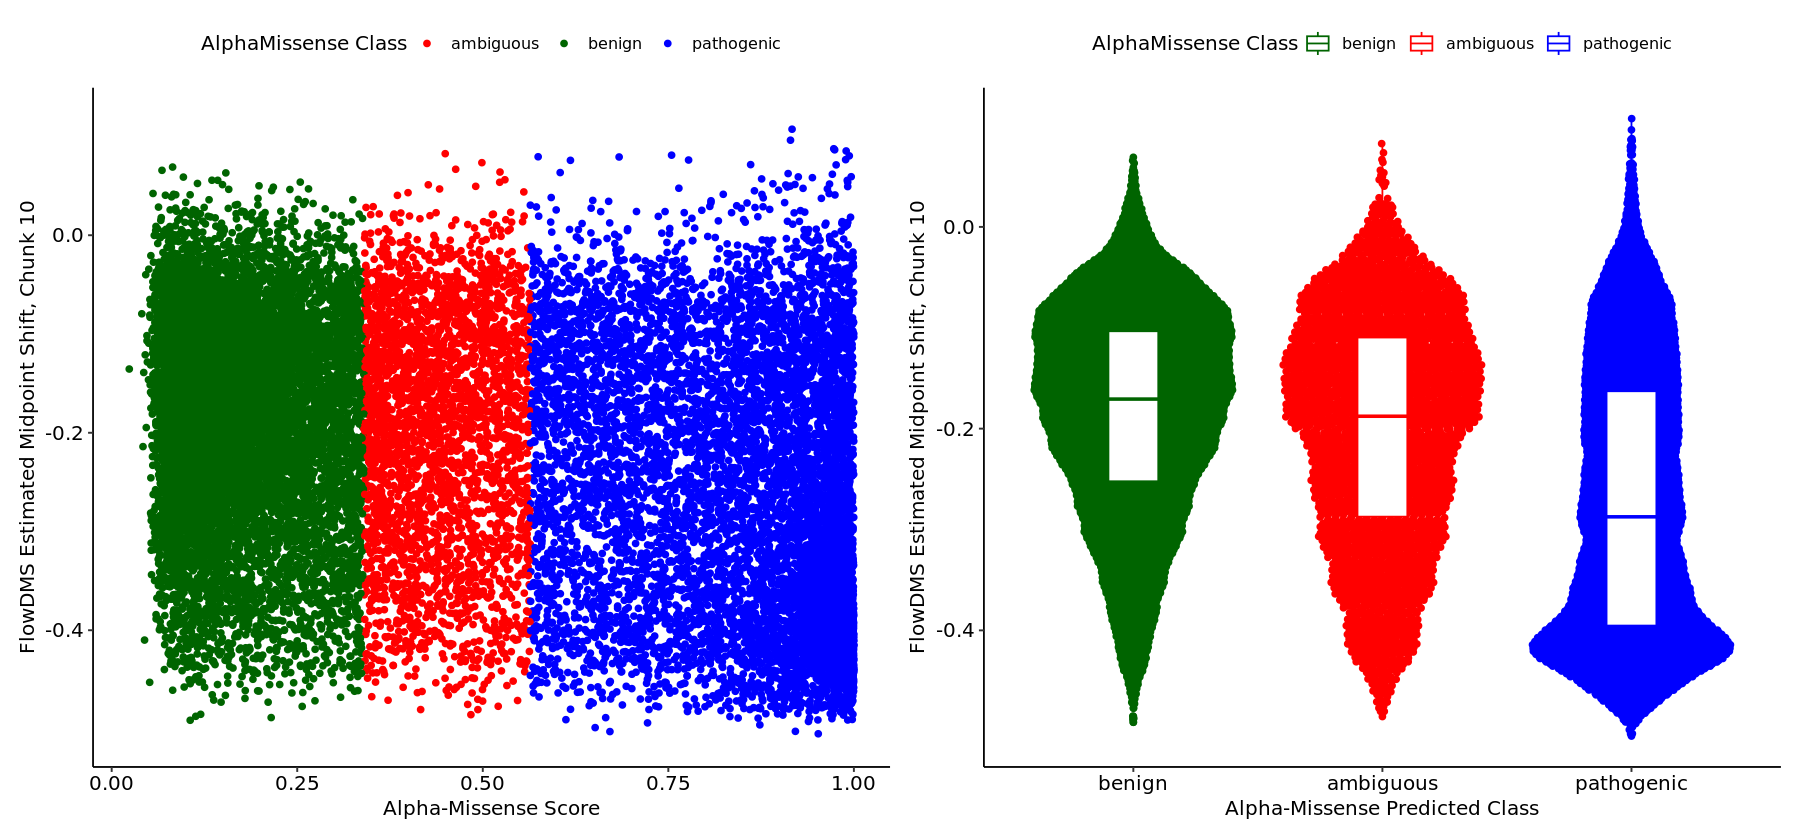

In [143]:
options(repr.plot.width = 15, repr.plot.height = 7, warn = -1)
p1 + p2